In [8]:
# import
import warnings
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler


class Samples_container:
    imgs_real_part = glob(".RoboCup_Cam/Assets/real/part/*.jpg")
    imgs_color_black = glob(".RoboCup_Cam/Assets/real/color/black/*.jpg")
    imgs_color_white = glob(".RoboCup_Cam/Assets/real/color/white/*.jpg")
    imgs_color_green = glob(".RoboCup_Cam/Assets/real/color/green/*.jpg")
    imgs_color_red = glob(".RoboCup_Cam/Assets/real/color/red/*.jpg")
    imgs_entire = glob(".RoboCup_Cam/Assets/real/entire/*.jpg")
    imgs_part = glob(".RoboCup_Cam/Assets/real/part/*.jpg")


In [9]:
# initial settings

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)

warnings.simplefilter('ignore')  # すべての警告を非表示にする


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


samples = Samples_container()


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


In [10]:
%%time
def prepare_bgr(paths, code):
    temp_raw = [[[[
        [pixel for pixel in line]
        for line in frame]
        for frame in cv2.resize(cv2.imread(path), (1280, 720))]
    ]for path in paths
    ]
    temp = np.reshape(temp_raw, newshape=(-1, 3)).astype(np.int64)
    temp_code = np.ones(len(temp)) * code
    return np.insert(temp, 3, temp_code, axis=1)


color_white = prepare_bgr(samples.imgs_color_white, 0)
color_black = prepare_bgr(samples.imgs_color_black, 1)
color_green = prepare_bgr(samples.imgs_color_green, 2)
color_red = prepare_bgr(samples.imgs_color_red, 3)

color_all = np.concatenate([color_black, color_green, color_white, color_red, ])

df = pd.DataFrame([
    np.append("{:,}".format(len(color_black)), np.average(color_black[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_green)), np.average(color_green[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_white)), np.average(color_white[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_red)), np.average(color_red[:2], axis=0).astype(np.int32)),
], index=["Black", "Green", "White", "Red"], columns=["Samples", "Ave. B", "Ave. G", "Ave. R", "Linked code"])

X_train, X_test, y_train, y_test = train_test_split(
    color_all[:, :-1],
    color_all[:, -1:],
    stratify=color_all[:, -1:],  # テストに使うデータを階層化する
    test_size=0.5,  # テストに使う割合
)
print("Train sample: {:,}".format(len(X_train)))

df = df.sort_values("Linked code")
df


Train sample: 4,608,000
Wall time: 43.2 s


,Samples,Ave. B,Ave. G,Ave. R,Linked code
White,"1,843,200",156,177,188,0
Black,"2,764,800",3,3,3,1
Green,"2,764,800",136,155,4,2
Red,"1,843,200",43,54,176,3


In [11]:
%%time

col_model = LinearSVC().fit(X_train, y_train)

y_pred = col_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))
SaveInstances(col_model, "./ColorReco2.pickle")


Color recognize model >>  LinearSVC()
Timer: 0.35106sec
Frame: 3,468px 4,624px


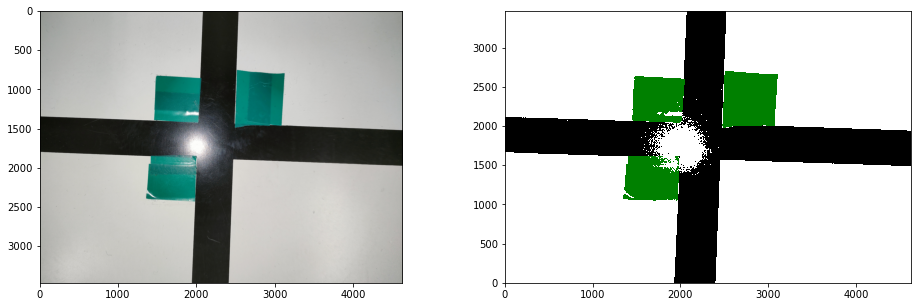

Timer: 0.35807sec
Frame: 3,468px 4,624px


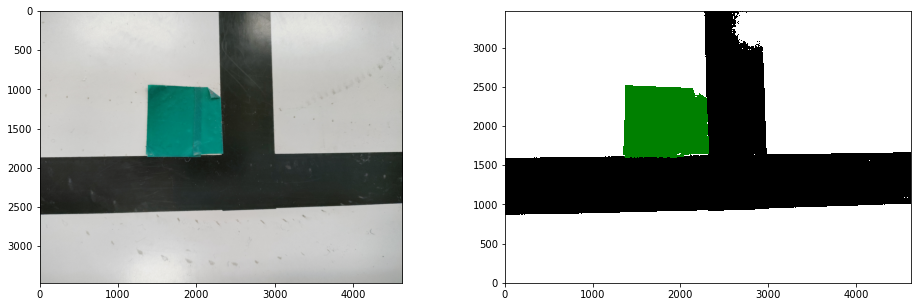

Timer: 0.35904sec
Frame: 3,468px 4,624px


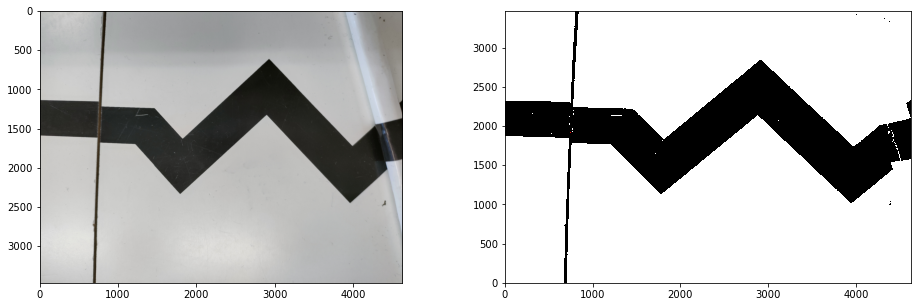

Timer: 0.36205sec
Frame: 3,468px 4,624px


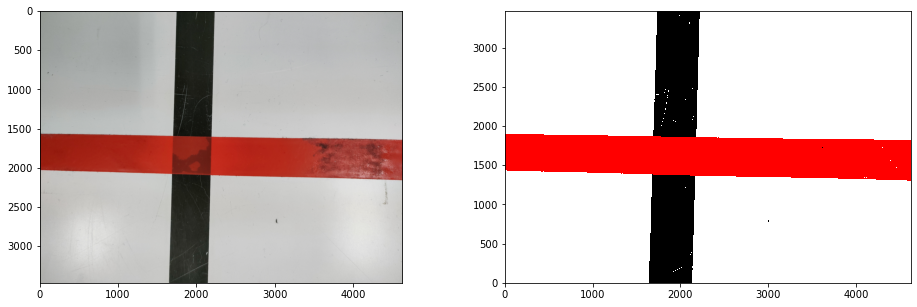

Timer: 0.36104sec
Frame: 3,468px 4,624px


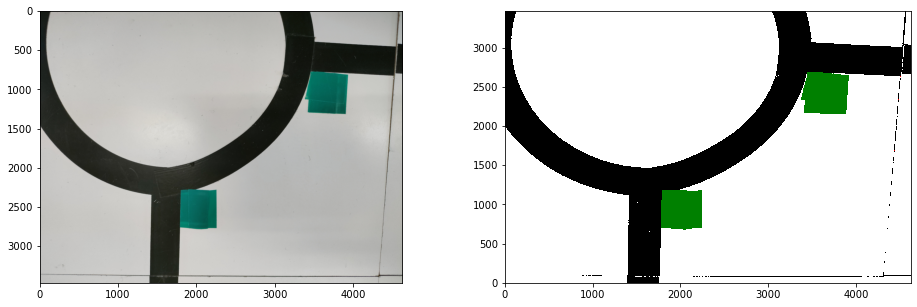

Timer: 0.36103sec
Frame: 3,468px 4,624px


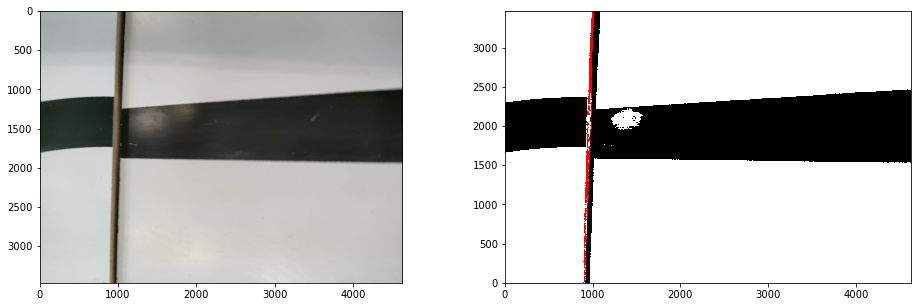

Timer: 0.36302sec
Frame: 3,468px 4,624px


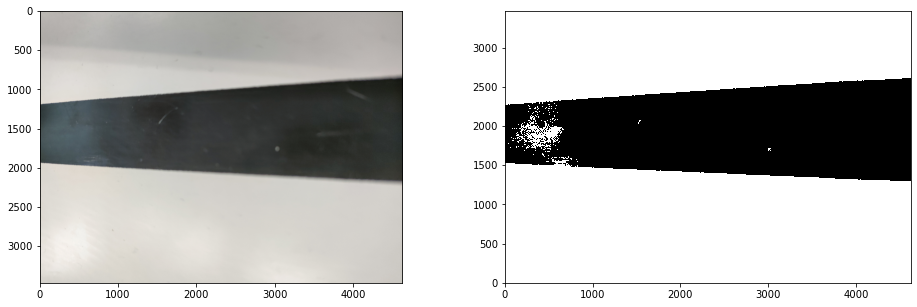

Timer: 0.38696sec
Frame: 3,468px 4,624px


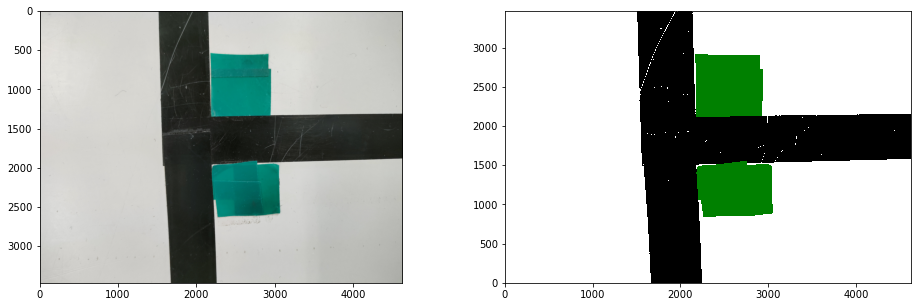

Timer: 0.34505sec
Frame: 3,468px 3,468px


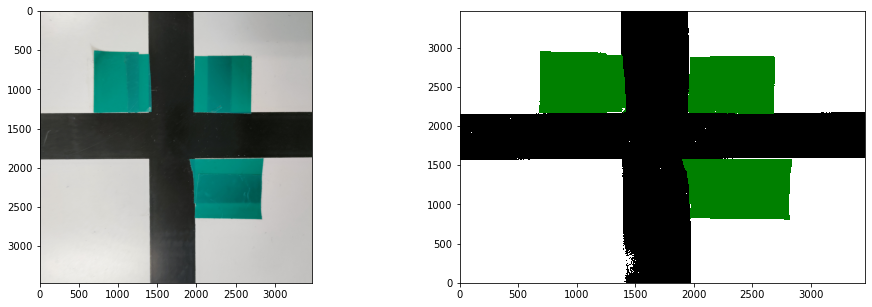

Timer: 0.35904sec
Frame: 3,468px 3,468px


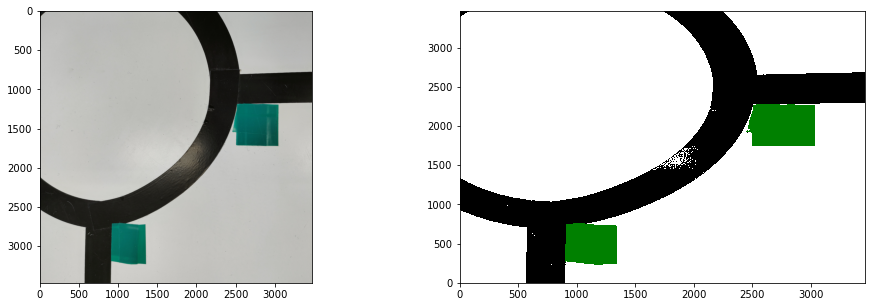

Timer: 0.33108sec
Frame: 3,468px 3,468px


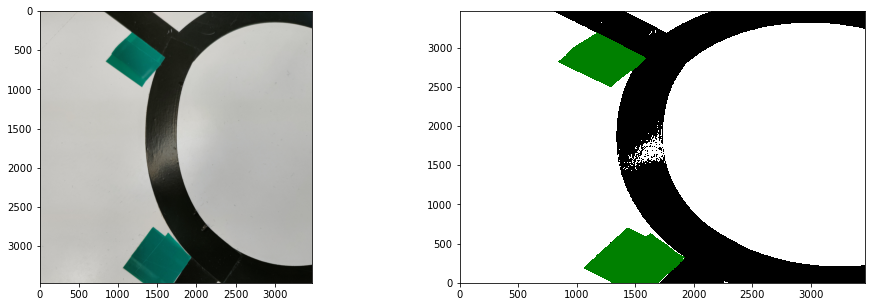

Timer: 0.31316sec
Frame: 3,468px 3,468px


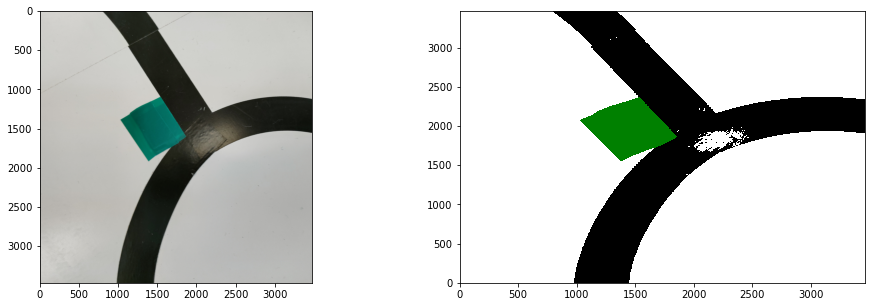

Timer: 0.31619sec
Frame: 3,468px 3,468px


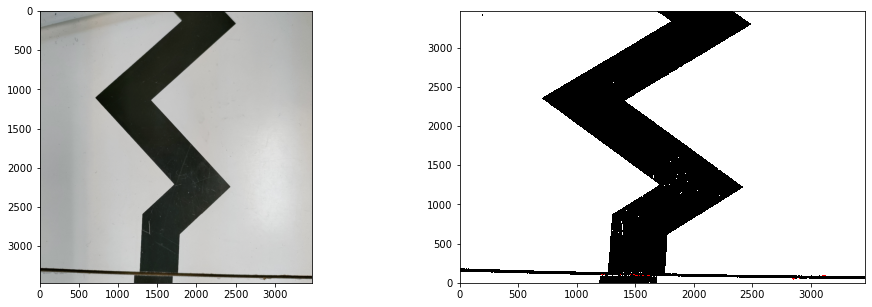

Timer: 0.30818sec
Frame: 3,468px 3,468px


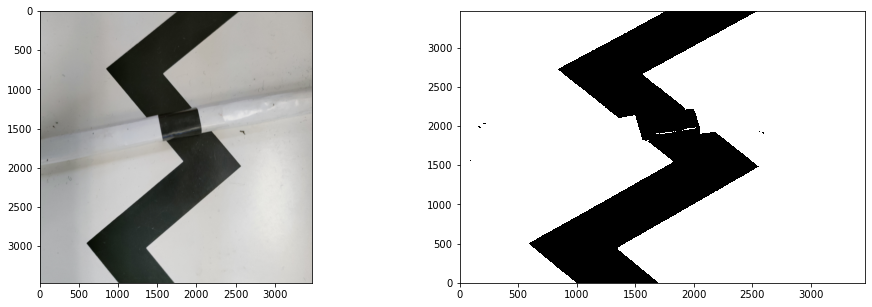

Timer: 0.30917sec
Frame: 3,468px 3,468px


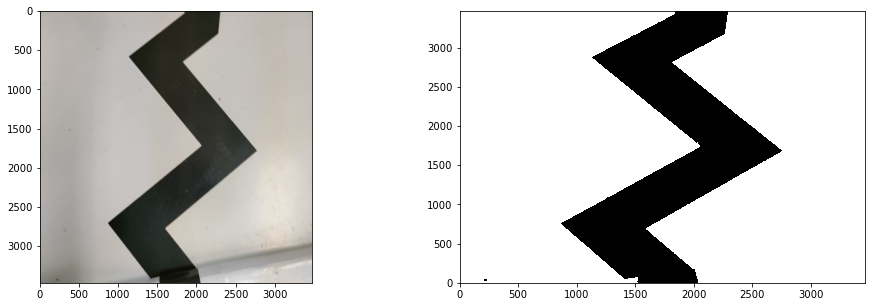

Timer: 0.32214sec
Frame: 3,468px 3,468px


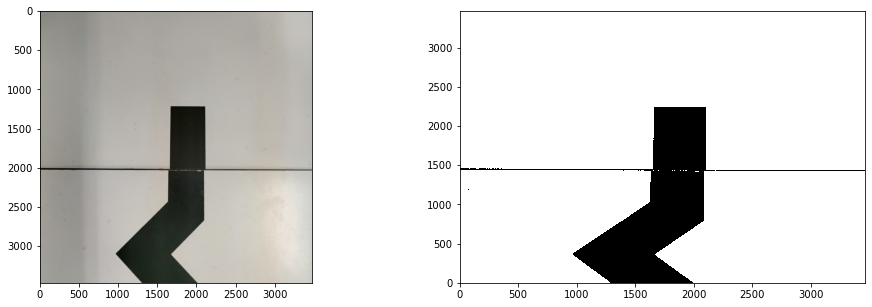

Timer: 0.31715sec
Frame: 3,468px 3,468px


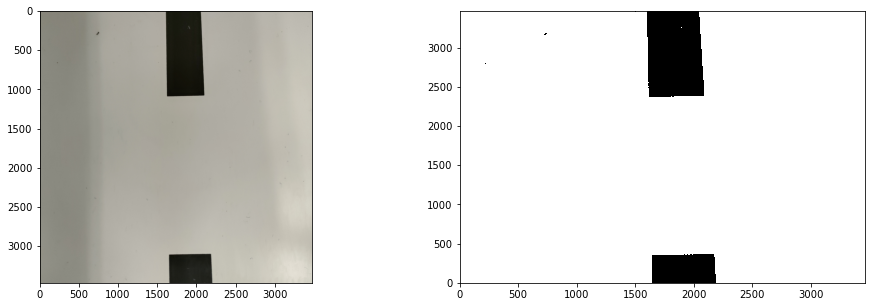

Timer: 0.31715sec
Frame: 3,468px 3,468px


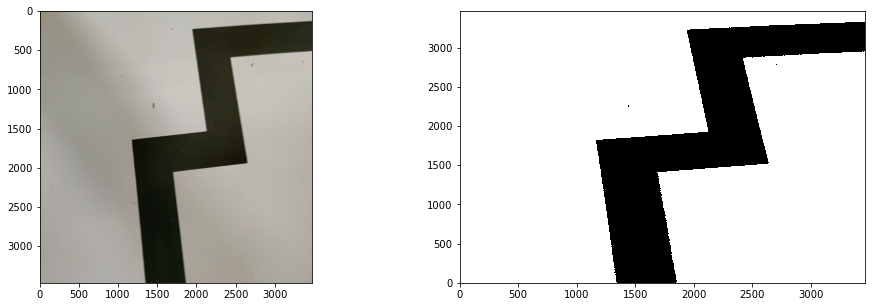

Timer: 0.33120sec
Frame: 3,468px 3,468px


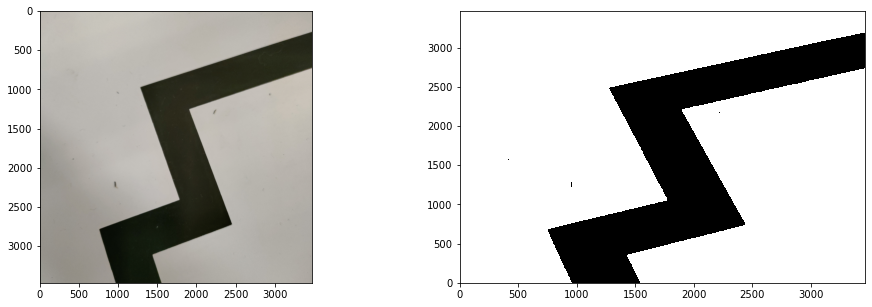

Wall time: 1min 35s


In [ ]:
%%time

""" 注意
https://teratail.com/questions/114307

OpenCVはBGR順、matplotlibはRGB順を前提として扱います。
cv2.cvtColor(img, cv2.COLOR_BGR2RGB)にてRGB順に並べ替えることでmatplotlibでも正しい色で表示できるようになります。
"""

print("Color recognize model >> ", col_model)

# カラーパレットを用意する
from matplotlib.colors import ListedColormap
colors = df.index
cmap = ListedColormap(colors, name="custom")

for path in samples.imgs_part:

    # 写真を読み込む
    entire_img = cv2.imread(path)
    # entire_img = cv2.resize(entire_img, (64, 36))
    entire_height, entire_width = entire_img.shape[:2]

    # 色を識別する
    timer_begin = time()
    entire_img_result = [col_model.predict(row) for row in reversed(entire_img)]
    # print(np.array(entire_img_result) * np.reshape(np.arange(0, len(entire_img_result), 1), (-1, 1)))
    print("Timer: {:,.5f}sec\nFrame: {:,}px {:,}px".format(time() - timer_begin, entire_height, entire_width))

    # 表示用に調整する
    entire_img_result[0][0] = df.loc["Black", "Linked code"]  # black
    entire_img_result[0][1] = df.loc["Green", "Linked code"]  # green
    entire_img_result[0][2] = df.loc["White", "Linked code"]  # white
    entire_img_result[0][3] = df.loc["Red", "Linked code"]  # red

    # 表示
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(entire_img, cv2.COLOR_BGR2RGB))  # -> 注意
    plt.subplot(122)
    plt.pcolormesh(entire_img_result, cmap=cmap)
    plt.show()
